In [122]:
import json
import pandas as pd
import numpy as np
import ast

from langchain.llms import OpenAI 
from langchain.chat_models import ChatOpenAI  
from langchain.callbacks import get_openai_callback
from langchain.schema.messages import HumanMessage, SystemMessage

In [123]:
with open("config.json", "r") as config_file:
    config = json.load(config_file)

In [124]:
openai_api_key = config["api_keys"]["openai"]

In [125]:
dataset = pd.read_csv(input("Enter testing dataset path: "))

In [153]:
with open('prompt_template.txt', 'r') as template_file:
    template = template_file.read()

In [127]:
with open(input("Enter EDAM topics file:"), 'r') as edam_file:
    full_edam_topics = edam_file.readlines()

full_edam_topics = [topic.strip() for topic in full_edam_topics]

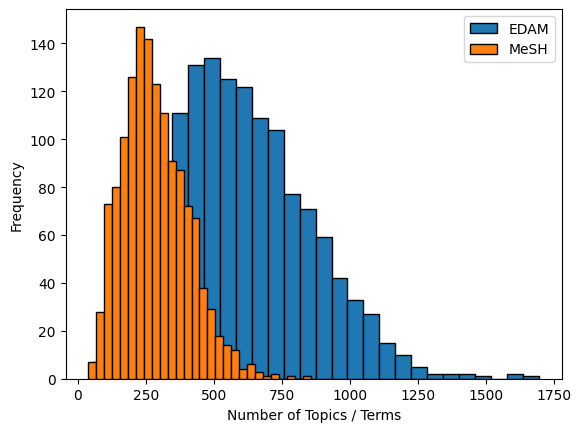

In [128]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black')
plt.hist(dataset['MeSH Terms'].apply(len), bins='auto', edgecolor='black')

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'MeSH'])

In [129]:
print("Total MeSH Terms:", len(list(dataset.iloc[0]['MeSH Terms'])))
print("Unique MeSH Terms:", len(np.unique(list(dataset.iloc[0]['MeSH Terms']))))
print()
print("Total EDAM Topics:", len(list(dataset.iloc[0]['EDAM Topics'])))
print("Unique EDAM Topics:", len(np.unique(list(dataset.iloc[0]['EDAM Topics']))))

Total MeSH Terms: 459
Unique MeSH Terms: 52

Total EDAM Topics: 758
Unique EDAM Topics: 46


In [130]:
dataset['MeSH Terms'] = dataset['MeSH Terms'].apply(lambda mesh_list: np.unique(ast.literal_eval((mesh_list))))
dataset['EDAM Topics'] = dataset['EDAM Topics'].apply(lambda edam_list: np.unique(ast.literal_eval((edam_list))))

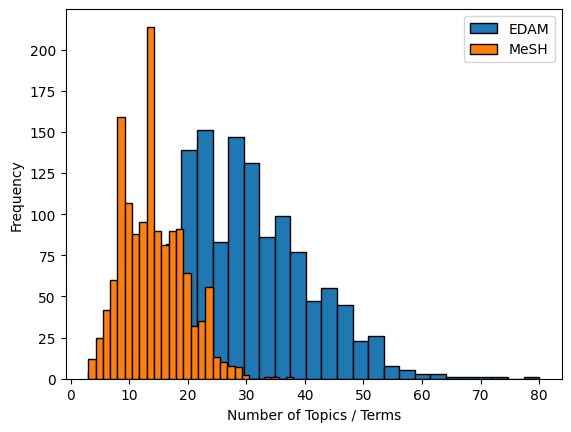

In [131]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black')
plt.hist(dataset['MeSH Terms'].apply(len), bins='auto', edgecolor='black')

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'MeSH'])

## Remove any topics not in the EDAM Topics list

In [132]:
dataset['Filtered EDAM'] = dataset['EDAM Topics'].apply(lambda x: [item for item in x if item in full_edam_topics])

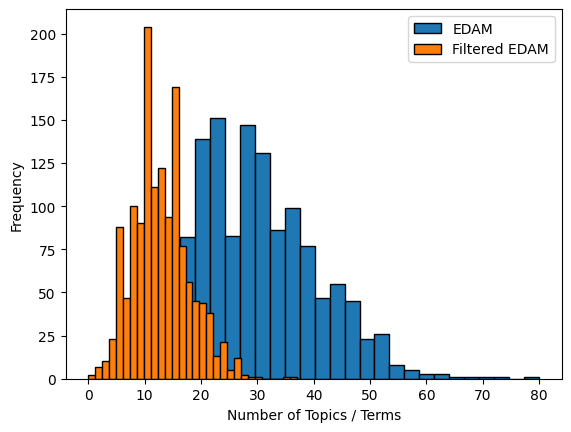

In [133]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(dataset['EDAM Topics'].apply(len), bins='auto', edgecolor='black')
plt.hist(dataset['Filtered EDAM'].apply(len), bins='auto', edgecolor='black')

plt.xlabel('Number of Topics / Terms')
plt.ylabel('Frequency')

plt.legend(['EDAM', 'Filtered EDAM'])

In [134]:
indices_true = dataset.loc[dataset['Filtered EDAM'].apply(lambda edam_list: not all(term in full_edam_topics for term in edam_list))].index

for index in indices_true:
    edam_list = dataset.loc[index, 'Filtered EDAM']
    terms_not_in_edam_topics = [term for term in edam_list if term not in full_edam_topics]
    
    print(f"Index {index}: Terms not in edam_topics: {terms_not_in_edam_topics}")

## OpenAI API

Let's start with a proof of concept:

In [135]:
description, abstract, paper_edam_topics = dataset.iloc[0][['Description', 'Abstract', 'Filtered EDAM']]

In [154]:
prompt = template.replace('<abstract>', abstract).replace('<num_terms>', str(len(paper_edam_topics)))
# prompt = template.replace('<abstract>', description).replace('<num_terms>', str(len(paper_edam_topics)))

In [155]:
print(prompt)

I have an abstract associated with a scientific dataset quoted here: 
"The Coronaviridae are a family of viruses that cause disease in humans ranging from mild respiratory infection to potentially lethal acute respiratory distress syndrome. Finding host factors common to multiple coronaviruses could facilitate the development of therapies to combat current and future coronavirus pandemics. Here, we conducted genome-wide CRISPR screens in cells infected by SARS-CoV-2 as well as two seasonally circulating common cold coronaviruses, OC43 and 229E. This approach correctly identified the distinct viral entry factors ACE2 (for SARS-CoV-2), aminopeptidase N (for 229E), and glycosaminoglycans (for OC43). Additionally, we identified phosphatidylinositol phosphate biosynthesis and cholesterol homeostasis as critical host pathways supporting infection by all three coronaviruses. By contrast, the lysosomal protein TMEM106B appeared unique to SARS-CoV-2 infection. Pharmacological inhibition of phos

In [156]:
messages = [
    SystemMessage(content=f"You're a helpful assistant."),
    HumanMessage(content=prompt)
]

chat = ChatOpenAI(
    model_name='gpt-3.5-turbo',
    openai_api_key = openai_api_key
)

In [157]:
with get_openai_callback() as cb:
    chat.invoke(messages)
    for chunk in chat.stream(messages):
        print(chunk.content, end="", flush=True)
    print("\n===========CALLBACK: ==========\n")
    print(cb)
    print("\n=============\n")

Infectious disease
Genome annotation
Genomics
Host-directed therapies
Drug discovery
Host factors
CRISPR screens
Phosphatidylinositol phosphate biosynthesis
Cholesterol homeostasis
Viral entry factors
Pharmacological inhibition
Coronavirus life cycle
Viral replication
Coronavirus pandemics
SARS-CoV-2 infection
Common cold coronaviruses
ACE2 receptor
Aminopeptidase N
Glycosaminoglycans
TMEM106B protein
===========CALLBACK: ==========

Tokens Used: 2557
	Prompt Tokens: 2469
	Completion Tokens: 88
Successful Requests: 1
Total Cost (USD): $0.0038794999999999997




In [140]:
gpt_output = "Genomics, CRISPR, Host-pathogen interaction, Human genetics, Virus-host interaction, Cell biology, Viral infection, Viral genomics, High-throughput screening, Human biology, Human disease, Genotype and phenotype, Genetics, Genome resequencing, Genomic variation, Viral genomics, Viral infection, Host-pathogen interaction, High-throughput screening".split(", ")

In [144]:
not_in_edam = 0

true_topics = dataset.iloc[0]['Filtered EDAM']
num_correct = 0

for topic in gpt_output:
    if topic not in full_edam_topics:
        print(topic)
        not_in_edam += 1
        continue

    if topic in true_topics:
        num_correct += 1

CRISPR
Host-pathogen interaction
Virus-host interaction
Viral infection
Viral genomics
High-throughput screening
Genomic variation
Viral genomics
Viral infection
Host-pathogen interaction
High-throughput screening


In [142]:
print("GPT-outputted topics not in EDAM:", not_in_edam)
print("# Correct topics from GPT:", num_correct)
print("# Missing topics from GPT:", len(true_topics) - num_correct)

GPT-outputted topics not in EDAM: 11
# Correct topics from GPT: 3
# Missing topics from GPT: 16
